# Modules to be Installed
The following modules are required for this project:

- `os`
- `sys`
- `gmsh`
- `numpy` (`np`)
- `pandas` (`pd`)
- `pyvista` (`pv`)
- `matplotlib.pyplot` (`plt`)
- `math`
- `meshio`
- `gmshparser`
- `importlib`
-  `math`
- `shapely.geometry`
```markdown
To install these modules, use the following pip command:

```bash
pip install os sys gmsh numpy pandas pyvista matplotlib math meshio gmshparser importlib

```

# Predicting 2 D water and heat fluxes from temperature measurements and differential pressure

We will use `ginette` to predict streambed discharge from temperature measurements in real time. In particular, the class `tempest1d.EKF` provides an extended Kalman filter. Here's an example.

You can find the `ginette` repository on GitHub: [ginette GitHub Repository](https://github.com/agnes-riviere/ginette)

Ginette models temperature by solving a two-dimensional, unsaturated and fully saturated form of the hydrologic energy transport equation [1]. In three dimensions, the equation is

$\frac{d}{dt} \left( \left[\phi {C}_w + \left( 1-\phi \right) {C}_{sed} \right] T \right) = \nabla \cdot \left( \lambda \nabla T \right) - \nabla \cdot \left( \phi {C}_w \vec{v} T \right)$,

where 
$t$ is time in s,
$\phi$ is porosity (a unitless fraction of total volume),
${C}_w$ is the volumetric specific heat capacity of water in J/m$^3$&deg;C,
${C}_{sed}$ is the volumetric specific heat capacity of the dry sediments in J/m$^3$&deg;C,
$T$ is temperature in &deg;C,
$\lambda$ is the thermal conductivity of the porous media in W/m&deg;C (4 models are available to take account ice, water, solid and air),
and $\vec{v}$ is the water velocity in m/s.


## Mass Balance Equation for Pore-Water Pressure

The mass balance equation used to calculate the pore-water pressure in the ($x$,$z$) plane is written:

$\frac{\partial}{\partial{x}} \left(\frac{\rho_w k k_r(T)}{\mu} \left(\frac{\partial{p}}{\partial{x}}\right)\right) + \frac{\partial}{\partial{z}} \left(\frac{\rho_w k k_r(T)}{\mu} \left(\frac{\partial{p}}{\partial{z}}+\rho_w g\right)\right) = \frac{S_{k}}{g} \frac{\partial{p}}{\partial{t}}  $

where 
- $t$ is time (s),
- $p$ is the pressure (Pa),
- $k$ is the intrinsic permeability ($m^{2}$),
- $k_{r}$(T,Sat) is the relative permeability,
- $g$ is the acceleration due to gravity (m\,$s^{-2}$),
- $\mu$ is the dynamic viscosity of water (Pa\,s),
- $\rho_{w}$ is the density of water (kg\,$m^{-3}$),
- $S_{k}$ is the specific storage coefficient ($m^{-1}$, see below).

The specific storage coefficient for fully saturated cells  is the specific storage coefficient $S_{s}$ in case of confined aquifer.

$S_{k}=S_{s}= \rho_{w} \, g \, n \, \left(\beta_f-\beta_s + \frac{\alpha_{c}}{ n }\right)$ , 

where 
- $n$ is the total porosity,
- $\beta_f$ is the compressibility of water ($Pa^{-1}$),
- $\beta_s$ is the compressibility of the solid rock grains ($Pa^{-1}$),
- $\alpha_c$ is the compressibility coefficient of the porous medium ($Pa^{-1}$).

For the unconfined aquifer, the specific storage coefficient is written:

$
S_{k}=\frac{n_{d}}{e \, s_{w}},
$

with 
- $n_{d}$ the drainable porosity,
- $e$ the thickness of the grid cell (m),
- $s_{w}$ the saturation of  water.
  
The Richards equation is also implemented but we won"t use it.




In [92]:
# appel fonction mesh
# -*- coding: utf-8 -*-
"""
Created on Wed Oct 18 14:57:23 2023
import functions mesh
"""
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys
import math
import matplotlib.pyplot as plt
# Ajouter le chemin du dossier src au PYTHONPATH
import importlib
sys.path.append('/home/ariviere/Programmes/ginette')  # Ajouter le dossier parent de src
from src.src_gmsh import mesh_generator
from src.src_python import Read_obs
from src.src_python import Direct_model
from src.src_python import Plot
importlib.reload(mesh_generator)
from src.src_gmsh.mesh_generator import *
from src.src_python.Init_folders import *
from src.src_python.Direct_model import *
from src.src_python.Read_obs import *
from src.src_python.Plot import *
# from src.src_python.Plot import *
#print functions of Init_folders

importlib.reload(Read_obs)
importlib.reload(mesh_generator)
importlib.reload(Plot)
# give me all names of the functions in Init_folders
#print(Init_folders.__dict__)
#print([name for name in dir(Init_folders) if callable(getattr(Init_folders, name)) and not name.startswith("__")])

compile_ginette()

ginette exists


In [141]:
# Configuration du répertoire de travail
# Utiliser os.getcwd() pour obtenir le répertoire de travail actuel
script_dir = os.getcwd()  # Répertoire du notebook
mesh_dir = os.path.join(script_dir, "meshdata")  # Chemin absolu vers "meshdata"
sim_dir= script_dir
file_path = "/home/ariviere/Documents/Bassin_Orgeval/Donnee_Orgeval_Mines/raw_data/DESC_data/DATA_STATION/"  # Chemin vers le fichier CSV
obs_dir=os.path.abspath(os.path.join(file_path, "../../../processed_data/"))
# Ajouter le chemin du dossier src au PYTHONPATH
sys.path.insert(0, "/home/ariviere/Programmes/ginette/src")
# Paramètres de du maillage
## name de la station
Station = "IntD"
# Paramètres sens de la station par rapport à la direction de la rivière
#       |   ↑    |
#  RG   |   ↑    |  RD
#       |        |
#  Rive_D=0 station à l'envers x_piezo_RD=0m dans l'exemple du schema
Rive_D=0
plot=True
meshplot=True
altitude_min = 103
dz_pt100=0.15
dz_pt100first=0.1
dt=900
date_simul_bg = pd.to_datetime("2013/04/19 12:00:00")
nb_day = 10
desc_station = {'RD': 'pzps8', 'RG': "PZ1", 'RIV': "rivgil"}
# Call the function to get the river mesh indices identifiant mesh cell
xRG=4.6
xRD=12.4
# Zone parameters
parameters=['k', 'n', 'l', 'cs', 'r']
nb_zone=5

In [ ]:
from src.src_python.Plot import plot_obs_station
plot_obs_station(Station,obs_dir,start_date='2014-12-12',end_date='2013-05-10')

# zone of hydrofacies

Chemin du fichier de nivellement CSV : /home/ariviere/Documents/Bassin_Orgeval/Donnee_Orgeval_Mines/raw_data/DESC_data/DATA_STATION/IntD/IntD.csv


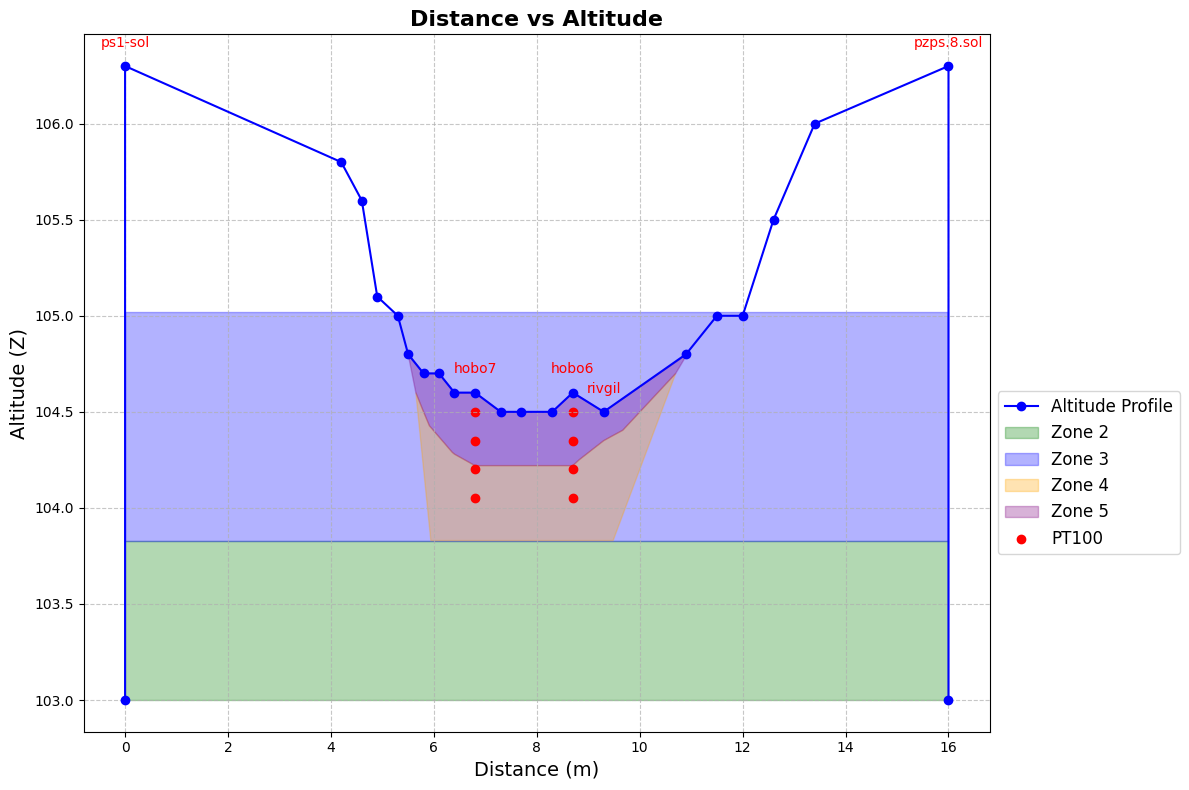

In [ ]:
# reading the data georef
distance_altitude_table,pt100_coord= process_distance_altitude(file_path, Station, mesh_dir, altitude_min, Rive_D,dz_pt100=dz_pt100,dz_pt100first=dz_pt100first)    


# definition des zones zones
#zone 1 
#zone 2
rect_2 = np.array([[0, 103.], [16, 103.],[16., 103.83],[0, 103.83]])
# zone 3
rect_3= np.array([[0, 103.83], [16, 103.83],[16, 105.02],[0, 105.02]])
# zone 4
poly_4=np.array([[10.7,104.7],[9.67076,104.40417],[9.48341,104.37706],[9.3,104.35],
                 [8.82518,104.25082],[8.7,104.22],[8.35,104.22],[7.3,104.22],
                 [6.8,104.22],[6.4,104.28],[6.35819,104.28925],
                 [5.91353,104.42771],[5.8,104.5],[5.65,104.6],
                 [5.94139,103.83],
               [6.8832,103.83],[7.40838,103.83],[8.06661,103.83], 
                 [9.3,103.83],[9.48341,103.83]
                ])
# zone 5        
poly_5=np.array([[10.7,104.7],[9.67076,104.40417],[9.48341,104.37706],[9.3,104.35],
                 [8.82518,104.25082],[8.7,104.22],[8.35,104.22],[7.3,104.22],
                 [6.8,104.22],[6.4,104.28],[6.35819,104.28925],
                 [5.91353,104.42771],[5.8,104.5],[5.65,104.6],[5.5,104.8],
                 [5.8,104.7],[6.1,104.7],[6.4,104.6],[6.8,104.6],
                 [7.3,104.5],[7.7,104.5],[8.3,104.5],[8.7,104.6],[9.3,104.5],[10.92239,104.8]]) 
# 
# 
#    
# plot des données
if plot:
    

    # Configure the plot
    plt.figure(figsize=(12, 8))
    plt.plot(
        distance_altitude_table["Distance (m)"],
        distance_altitude_table["Altitude (Z)"],
        marker='o',
        # add name distance_altitude_table["Instrument"] if not NA
        linestyle='-',
        color='blue',
        label='Altitude Profile'
    )

    # Ajouter les noms des instruments au-dessus des points si ce n'est pas "NA"
    for i, instrument in enumerate(distance_altitude_table["Instrument"]):
        if instrument != "NA" and not pd.isna(instrument):
            plt.text(
                distance_altitude_table["Distance (m)"][i],
                distance_altitude_table["Altitude (Z)"][i] + 0.1,  # Décalage vertical pour éviter de chevaucher le point
                instrument,
                fontsize=10,
                color='red',
                ha='center'
            )
    # Tracer les zones rectangulaires xmin ymin and xmax ymax

    plt.fill(rect_2[:, 0], rect_2[:, 1], color='green', alpha=0.3, label='Zone 2')
    plt.fill(rect_3[:, 0], rect_3[:, 1], color='blue', alpha=0.3, label='Zone 3')
    plt.fill(poly_4[:, 0], poly_4[:, 1], color='orange', alpha=0.3, label='Zone 4')
    plt.fill(poly_5[:, 0], poly_5[:, 1], color='purple', alpha=0.3, label='Zone 5')

# Tracer les capteurs de température PT100
# Tracer les capteurs de température PT100
    if not pt100_coord.empty:
        pt100_label_added = False  # Variable pour suivre si le label "PT100" a été ajouté
        for i in range(len(pt100_coord)):
            plt.scatter(
                pt100_coord["Distance (m)"][i],
                pt100_coord["Altitude (Z)"][i],
                color='red',
                label="PT100" if not pt100_label_added else None  # Ajouter le label uniquement une fois
            )
            pt100_label_added = True  # Marquer que le label a été ajouté
    # Add titles and labels    # Initialize the neighbors as -99 (no neighbor)
    # The neighbors are stored in the ivois DataFrame
    plt.title("Distance vs Altitude", fontsize=16, fontweight='bold')
    plt.xlabel("Distance (m)", fontsize=14)
    plt.ylabel("Altitude (Z)", fontsize=14)

    # Add grid and legend
    plt.grid(True, linestyle='--', alpha=0.7)
 # Ajouter la légende en dehors de la figure, à droite
    plt.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1, 0.5))

    # Show the plot
    plt.tight_layout()
    plt.show()
#     





# Read the observation data

This section focuses on reading and processing the observation data for the simulation. The data includes temperature and hydraulic head measurements from various sensors (e.g., PT100, Hobo) located at different positions in the domain. The processed data will be used as input for the simulation and validation of the model.


In [ ]:

all_data, hmax,hmin,hqt95=process_obs_RIV2D(Station, obs_dir, date_simul_bg, nb_day, desc_station, pt100_coord)


Start date: 2013-04-19 12:00:00 End date: 2013-04-29 12:00:00
Processing sensor type: PZ1
Processing sensor type: Hobo6


/home/ariviere/Programmes/ginette/src/src_python/Read_obs.py:103: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df[date_column] = pd.to_datetime(df[date_column], errors='raise')


Processing sensor type: pzps8
Processing sensor type: Hobo7


/home/ariviere/Programmes/ginette/src/src_python/Read_obs.py:103: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df[date_column] = pd.to_datetime(df[date_column], errors='raise')


Processing sensor type: rivgil


/home/ariviere/Programmes/ginette/src/src_python/Read_obs.py:103: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df[date_column] = pd.to_datetime(df[date_column], errors='raise')


# Build the model
## Build the mesh

The mesh is constructed with a rectangular domain, ensuring a structured grid for the simulation. The domain is divided into regions with varying resolutions to capture the necessary details for the model.

In [ ]:

## altitude min du maillage
x_hoboRG=6.8
x_hoboRD=8.7
z_hoboRG=104.5
z_hoboRD=104.5
x_RG=5.25
x_RD=10.25
z_riv=104.575
v_bot=104
dx_precis=0.10
dx_grossier=0.25
dz_grossier=0.25
dz_precis=0.05
dx_hobo=0.05
 # Calcul des subdivisions en x pour les regions centre 2 et 5
length_x_centre = x_RD-x_RG
num_div_x_centre = max(2, math.ceil(length_x_centre / dx_precis))
max_x=distance_altitude_table['Distance (m)'].max()
min_x=distance_altitude_table['Distance (m)'].min()
max_z=distance_altitude_table['Altitude (Z)'].max()
# Calcul des subdivisions en x pour les regions de gauche 1, 4 et 7
length_x_gauche = x_RG - min_x
num_div_x_gauche = max(2, math.ceil(length_x_gauche / dx_grossier))

        # Calcul des subdivisions en x pour les regions centre 2 et 5
length_x_centre = x_RD- x_RG
num_div_x_centre = max(2, math.ceil(length_x_centre / dx_precis))
# Calcul des subdivisions en x pour les regions droite 3, 6 et 8
length_x_droite = max_x - x_RD
num_div_x_droite = max(2, math.ceil(length_x_droite / dx_grossier))

        # Calcul des subdivisions en z pour les regions haute 7 et 8
num_div_z_haut = max(2, math.ceil((max_z - z_riv) / dz_grossier))
        # Ensure the number of subdivisions is an integer by adjusting the step size
if (max_z - z_riv) % dz_grossier != 0.1:
    num_div_z_haut = max(2, round((max_z - z_riv) / dz_grossier))
        
        # Calcul des subdivisions en z pour les regions centre 4, 5 et 6
num_div_z_centre = max(2, math.ceil((z_riv - v_bot) / dz_precis))

        # Calcul des subdivisions en z pour les regions bas 1,2 et 3
num_div_z_bas = max(2, math.ceil((v_bot - altitude_min)/dz_grossier))

print(f"Subdivisions calculées :\n"
            f"  - Gauche : {num_div_x_gauche} subdivisions\n"
            f" - dx gauche : {length_x_gauche / num_div_x_gauche:.2f} m\n"
            f"  - Centre : {num_div_x_centre} subdivisions\n"
            f" - dx centre : {length_x_centre / num_div_x_centre:.2f} m\n"
            f"  - Droite : {num_div_x_droite} subdivisions\n"
            f" - dx droite : {length_x_droite / num_div_x_droite:.2f} m\n"
            f"  - Haut : {num_div_z_haut} subdivisions\n"
            f" - dz haut : {(max_z - z_riv) / num_div_z_haut:.2f} m\n"
            f"  - Centre : {num_div_z_centre} subdivisions\n"
            f" - dz centre : {(z_riv - v_bot) / num_div_z_centre:.2f} m\n"
            f"  - Bas : {num_div_z_bas} subdivisions\n"
            f" - dz bas : {(v_bot - altitude_min) / num_div_z_bas:.2f} m\n")

Subdivisions calculées :
  - Gauche : 21 subdivisions
 - dx gauche : 0.25 m
  - Centre : 50 subdivisions
 - dx centre : 0.10 m
  - Droite : 23 subdivisions
 - dx droite : 0.25 m
  - Haut : 7 subdivisions
 - dz haut : 0.25 m
  - Centre : 12 subdivisions
 - dz centre : 0.05 m
  - Bas : 4 subdivisions
 - dz bas : 0.25 m



In [ ]:
if meshplot:
    # Appel de la fonction
    output_mesh_path = os.path.join(mesh_dir, "rectangular_mesh.msh")
    generate_mesh_8_region(distance_altitude_table, output_mesh_path,v_bot=v_bot,x_RG =x_RG, x_RD = x_RD,z_riv=z_riv, 
                           dx_grossier=dx_grossier, dx_precis = dx_precis,x_hobo_1 =x_hoboRG, z_hobo_1=z_hoboRG,x_hobo_2 = x_hoboRD,z_hobo_2=z_hoboRD, dx_hobo=dx_hobo, 
                           dz_grossier=dz_grossier, dz_precis=dz_precis,dz_hobo1=dz_pt100first,dz_hobo=dz_pt100,mesh_dimension=2)

    output_mesh_path = os.path.join(mesh_dir, "rectangular_mesh.msh")
    remove_elements_above_curve_all_entities(distance_altitude_table, output_mesh_path, ajout='_remove_all_entities', retirer='')
    plot_gmsh_mesh(output_mesh_path.replace(".msh", "_remove_all_entities.msh")) # Modification du nom car on applique 2 fois la fct remove elements 




Génération du maillage structuré avec Gmsh...
hobo 8.65 6.85 0.1 -59.84999999999999
Subdivisions calculées :
  - Gauche : 21 subdivisions
 - dx gauche : 0.25 m
  - Centre : 50 subdivisions
 - dx centre : 0.10 m
  - Droite : 23 subdivisions
 - dx droite : 0.25 m
  - Haut : 7 subdivisions
 - dz haut : 0.25 m
  - Centre : 12 subdivisions
 - dz centre : 0.05 m
  - Bas : 4 subdivisions
 - dz bas : 0.25 m

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 10%] Meshing curve 4 (Line)
Info    : [ 10%] Meshing curve 5 (Line)
Info    : [ 20%] Meshing curve 6 (Line)
Info    : [ 20%] Meshing curve 7 (Line)
Info    : [ 20%] Meshing curve 8 (Line)
Info    : [ 20%] Meshing curve 9 (Line)
Info    : [ 30%] Meshing curve 10 (Line)
Info    : [ 30%] Meshing curve 11 (Line)
Info    : [ 30%] Meshing curve 12 (Line)
Info    : [ 30%] Meshing curve 13 (Line)
Info    : [ 40%] Meshing curve 14 (Line)
Info  

Widget(value='<iframe src="http://localhost:40375/index.html?ui=P_0x788e8ffb58a0_5&reconnect=auto" class="pyvi…

## Creation of the Coordinate File

This section focuses on generating the coordinate file for the mesh. The file contains the x and z coordinates of the mesh centers, which are essential for defining the spatial structure of the simulation domain. The coordinates are extracted from the mesh data and saved in a format compatible with the simulation software.

In [ ]:

from src.src_gmsh import mesh_generator
importlib.reload(mesh_generator)

from src.src_gmsh.mesh_generator import readGmsh
fName = os.path.join(mesh_dir, "rectangular_mesh_remove_all_entities.msh")
# rename to pt100_coord with x and z
pt100_coord.rename(columns={"Distance (m)": "x", "Altitude (Z)": "z"}, inplace=True)

centres,nb_mesh,def_maille = readGmsh(fName, precision=3)
# write the coordinates in a file witout the header
centres.to_csv(os.path.join(sim_dir, "E_coordonnee.dat"), sep=' ', header=False, index=False)
def_maille.to_csv(os.path.join(sim_dir, "E_def_maille.dat"), sep=' ', header=False, index=False)

# write index with the first =1 in the first column of the centres dataframe
centres['index'] = np.arange(1, len(centres) + 1)




### Plot the Center of Cells

This section visualizes the center of each mesh cell in the domain. The plot provides a clear representation of the spatial distribution of the mesh centers, which is essential for understanding the structure of the simulation grid.

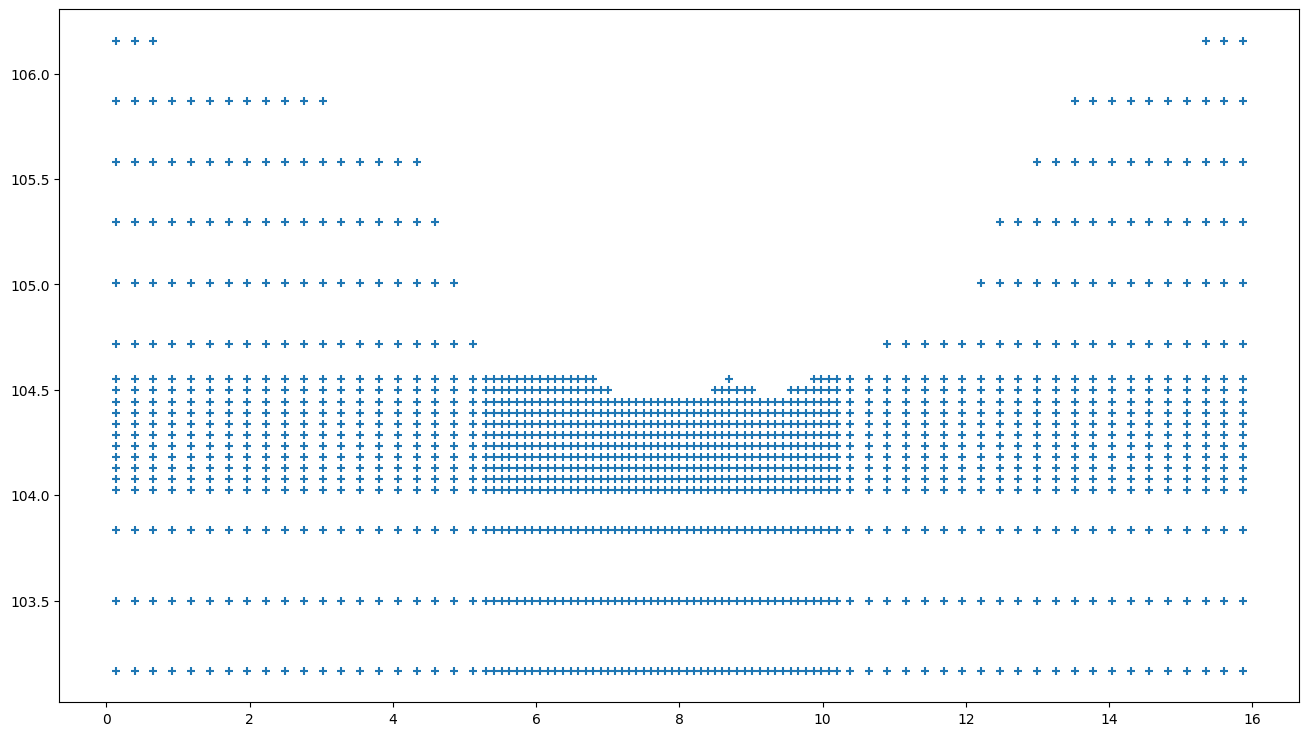

In [ ]:
# interactive corrdinates on the plot
x = centres['x']
z = centres['z']
fig, ax = plt.subplots(figsize = (16,9))

ax.scatter(x,z,marker="+") # Trace le centre de chaque mailles
plt.show()

## Index of the Temperature Sensors
The index corresponds to Ginette's `n_maille` values, which are saved for each temperature sensor.

In [ ]:
# Find the index of the mesh center nearest to each PT100 coordinate and add the corresponding information to pt100_coord
for i in range(len(pt100_coord)):
    # Calculate the index of the nearest mesh center to the current PT100 coordinate
    index = ((centres['x'] - pt100_coord["x"][i])**2 + (centres['z'] - pt100_coord["z"][i])**2).idxmin()
    
    # Add the index of the nearest mesh center to the pt100_coord DataFrame
    pt100_coord.loc[i, 'index'] = centres.loc[index, 'index']
    
    # Calculate and add the distance between the PT100 coordinate and the nearest mesh center
    pt100_coord.loc[i, 'distance'] = np.sqrt((centres['x'][index] - pt100_coord["x"][i])**2 + (centres['z'][index] - pt100_coord["z"][i])**2)
    
    # Add the x and z coordinates of the nearest mesh center to the pt100_coord DataFrame
    pt100_coord.loc[i, 'xmaille'] = centres.loc[index, 'x']
    pt100_coord.loc[i, 'zmaille'] = centres.loc[index, 'z']

# Convert the 'index' column to integers and store it in a new column 'n_maille'
pt100_coord['n_maille'] = pt100_coord['index'].astype(int)

# Display the first 8 rows of the updated pt100_coord DataFrame
print(pt100_coord.head(8))

    hobo  pt100    x       z  index  distance  xmaille  zmaille  n_maille
0  hobo7      1  6.8  104.50    567     0.003      6.8  104.497       567
1  hobo7      2  6.8  104.35    570     0.010      6.8  104.340       570
2  hobo7      3  6.8  104.20    573     0.017      6.8  104.183       573
3  hobo7      4  6.8  104.05    576     0.024      6.8  104.026       576
4  hobo6      1  8.7  104.50    801     0.003      8.7  104.497       801
5  hobo6      2  8.7  104.35    804     0.010      8.7  104.340       804
6  hobo6      3  8.7  104.20    807     0.017      8.7  104.183       807
7  hobo6      4  8.7  104.05    810     0.024      8.7  104.026       810


### Plot the Figure for Verification

This section visualizes the mesh centers and their indices to verify the spatial structure of the simulation grid. The plot provides a clear representation of the mesh layout, helping to ensure that the mesh is correctly defined and aligned with the simulation requirements.

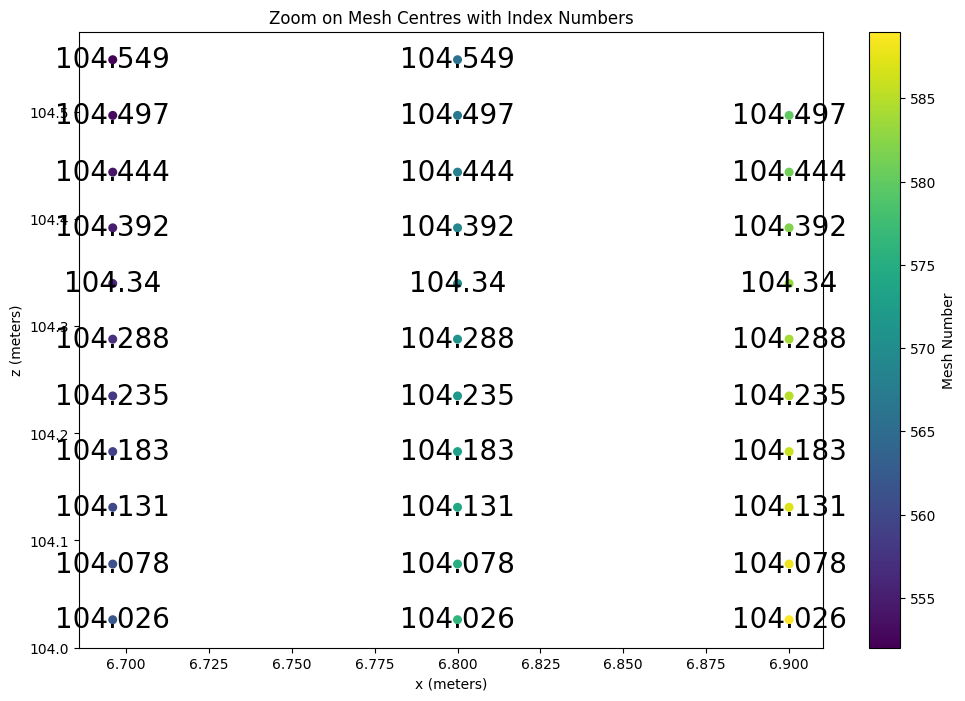

In [ ]:

# Filter to zoom in on the desired region
centres_zoom = centres[
    (centres['x'] > 6.6) & (centres['x'] < 7) &
    (centres['z'] > 104.) & (centres['z'] < 104.6)
]

# Plot the points
plt.figure(figsize=(12, 8))
plt.scatter(centres_zoom['x'], centres_zoom['z'], c=centres_zoom['index'], cmap='viridis', s=30)

# Add text labels for each point
for _, row in centres_zoom.iterrows():
    plt.text(row['x'], row['z'], str(row['z']), fontsize=20, color='black', ha='center', va='center')

# Add axis labels and a colorbar for clarity
plt.xlabel('x (meters)')
plt.ylabel('z (meters)')
plt.title('Zoom on Mesh Centres with Index Numbers')
plt.colorbar(label='Mesh Number')
plt.show()

## Creation of Dimensions
- `nb_col`: Number of columns in the mesh grid.
- `nb_row`: Number of rows in the mesh grid.

Create the files `E_colonne.dat` and `E_row.dat` to store the column and row indices of the mesh grid.

In [ ]:
# Call the function to calculate the number of columns and rows in the mesh grid
# This function reads the mesh data and determines the grid dimensions
nb_col, nb_row = coord_to_row_column(script_dir)

Found 20 distinct columns; max assigned column = 90
Found 90 distinct rows;    max assigned row    = 20


## Build the Neighbor Table
### and the Index of the Cell at the Right and Left Side of the Simulated Domain
- **col1**: Index of the right neighbor cell.
- **col2**: Index of the left neighbor cell.
- **col3**: Index of the top neighbor cell.
- **col4**: Index of the bottom neighbor cell.

In [ ]:
ivois = voisin_mesh(script_dir)
RG, RD = maille_limite(script_dir)

Neighbors saved to E_voisins.dat.


### Plot to check the index

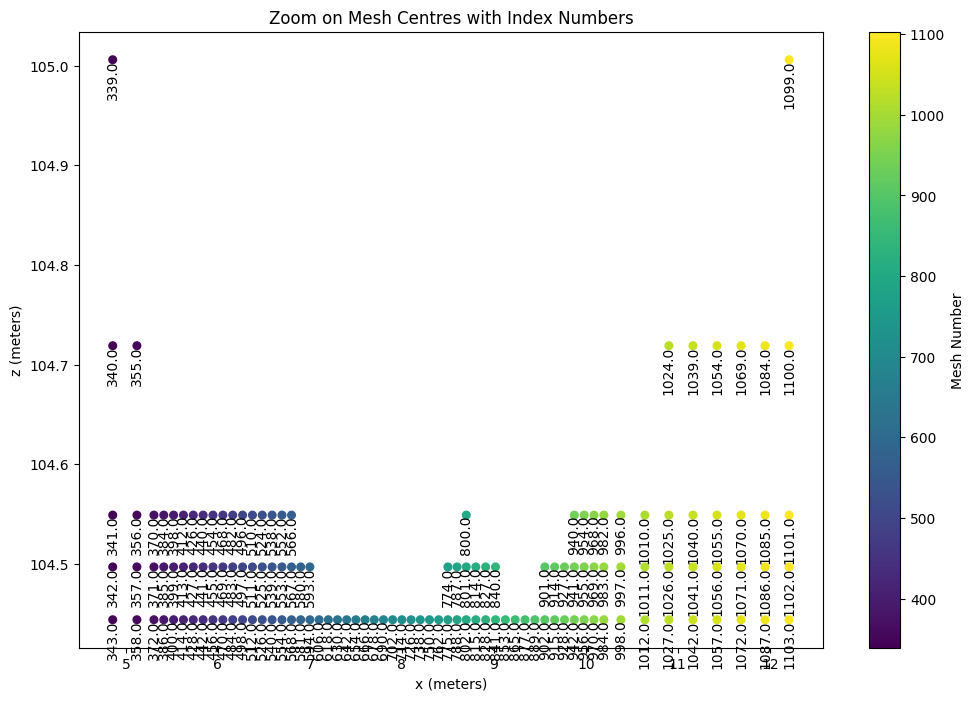

In [ ]:


# Filter to zoom in on the desired region
centres_zoom = centres[
    (centres['x'] > 4.6) & (centres['x'] < 12.4) &
    (centres['z'] > 104.4) & (centres['z'] < 106)
]

# Plot the points
plt.figure(figsize=(12, 8))
plt.scatter(centres_zoom['x'], centres_zoom['z'], c=centres_zoom['index'], cmap='viridis', s=30)

# Add text labels for each point with rotated text
for _, row in centres_zoom.iterrows():
    plt.text(row['x'], row['z'], str(row['index']), fontsize=10, color='black', ha='center', va='top', 
             rotation=90)



# Add axis labels and a colorbar for clarity
plt.xlabel('x (meters)')
plt.ylabel('z (meters)')
plt.title('Zoom on Mesh Centres with Index Numbers')
plt.colorbar(label='Mesh Number')
plt.show()


# River Identification

In [ ]:
river=id_mesh_river(script_dir,hmax,hmin,xRG,xRD)
id_river_min,id_river_max=river


# verif id river

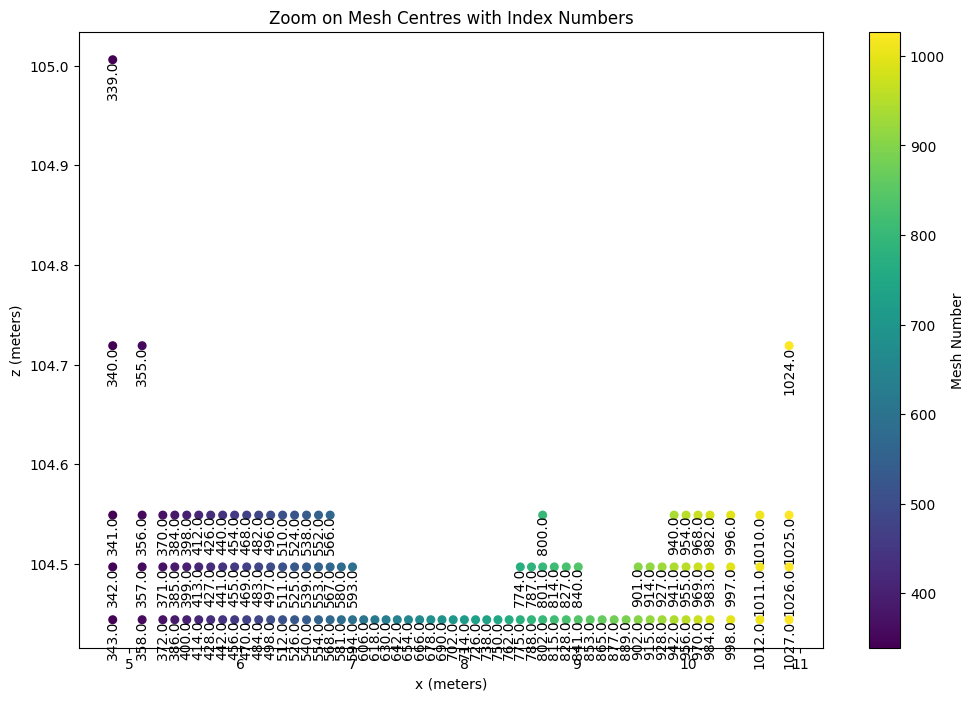

In [ ]:


# Filter to zoom in on the desired region
centres_zoom = centres[
    (centres['x'] > 4.8) & (centres['x'] < 11.1) &
    (centres['z'] > 104.4) & (centres['z'] < 106)
]

# Plot the points
plt.figure(figsize=(12, 8))
plt.scatter(centres_zoom['x'], centres_zoom['z'], c=centres_zoom['index'], cmap='viridis', s=30)

# Add text labels for each point with rotated text
for _, row in centres_zoom.iterrows():
    plt.text(row['x'], row['z'], str(row['index']), fontsize=10, color='black', ha='center', va='top', 
             rotation=90)



# Add axis labels and a colorbar for clarity
plt.xlabel('x (meters)')
plt.ylabel('z (meters)')
plt.title('Zoom on Mesh Centres with Index Numbers')
plt.colorbar(label='Mesh Number')
plt.show()

# Creation of E_zone.dat
* E_zone.dat: Zone number for each mesh cell, where each line corresponds to one integer.

    '''
    Function to populate the E_zone.dat file, which is required for Ginette. 
    This function uses the mesh data (E_coordonnee.dat file) and a DataFrame containing polygons organized by their respective zones. 
    The function checks whether the center of each mesh cell is located within a polygon. 
    Once the zone of the mesh cell is identified, it is added to a list, which is then written to the E_zone.dat file at the end of the function.

    Inputs:
    - polygons_by_zone (DataFrame): DataFrame containing the polygons that define the different zones of the mesh. 
      An example of creating polygons_by_zone is provided in the code.
    - default_zone (int): Default zone (default = 1) assigned to points not contained in any polygon. 
      This avoids the need to define all polygons in polygons_by_zone.
    '''

In [ ]:
# Define the polygons for each zone
# Ensure the order of polygons in the dictionary matches the zone numbers
polygons_by_zone = {
    5: [Polygon(poly_5)],  # Zone 5
    4: [Polygon(poly_4)],  # Zone 4
    2: [Polygon(rect_2)],  # Zone 2
    3: [Polygon(rect_3)]   # Zone 3
}

# Generate the E_zone.dat file
# This file assigns a zone number to each mesh cell based on the defined polygons
creation_E_zone(script_dir, polygons_by_zone, default_zone=1)

# Initialize the E_zone.dat file with default zone number 1 for all mesh cells
# Create a DataFrame with a single column 'zone' filled with the integer 1
zone = pd.DataFrame(np.ones((nb_mesh, 1), dtype=int), columns=['zone'])

# Save the zone DataFrame to the E_zone.dat file
# The file is saved without headers or indices
zone.to_csv(os.path.join(mesh_dir, "E_zone.dat"), sep=' ', header=False, index=False)


# Initial Parameters for Each Hydrofacies Zone

This section defines the physical and thermal parameters for each hydrofacies zone used in the simulation.

---

## Parameter Definitions

| Symbol | Name                                 | Unit                | Description                                 |
|--------|--------------------------------------|---------------------|---------------------------------------------|
| **k**  | Intrinsic permeability               | m²                  | Controls groundwater flow                   |
| **n**  | Porosity                             | (dimensionless, [-])| Fraction of void space                      |
| **l**  | Thermal conductivity of the solid    | W·m⁻¹·K⁻¹           | Heat transfer ability of the solid matrix   |
| **cₛ** | Specific heat capacity of the solid  | J·kg⁻¹·K⁻¹          | Heat storage capacity of the solid matrix   |
| **r**  | Density of the solid                 | kg·m⁻³              | Mass per unit volume of the solid matrix    |

---

## Heat Capacity Calculation in Ginette

The volumetric heat capacity ($ c_{pm} $) is computed as:

$$
c_{pm} = c_w \cdot \rho_w \cdot n \cdot \text{sat} + c_s \cdot \rho_s \cdot (1-n) + c_a \cdot \rho_a \cdot n \cdot (1-\text{sat})
$$

Where:

- $ c_w $: Specific heat capacity of water (J·kg⁻¹·K⁻¹)
- $ \rho_w $: Density of water (kg·m⁻³)
- $ n $: Porosity (dimensionless)
- $ \text{sat} $: Saturation (dimensionless)
- $ c_s $: Specific heat capacity of the solid (J·kg⁻¹·K⁻¹)
- $ \rho_s $: Density of the solid (kg·m⁻³)
- $ c_a $: Specific heat capacity of air (J·kg⁻¹·K⁻¹)
- $ \rho_a $: Density of air (kg·m⁻³)

> **Note:**  
> - The value of $ \rho_s $ (solid density) is typically kept constant.  
> - Avoid calibrating both $ \rho_s $ and $ c_s $ simultaneously to prevent non-uniqueness in parameter estimation.

---

## Effective Thermal Conductivity

The effective thermal conductivity of the aquifer (water + solid) is:

$$
\lambda_{\text{aquifer}} = \lambda_w \cdot n + \lambda_s \cdot (1-n)
$$

- $ \lambda_w $: Thermal conductivity of water (W·m⁻¹·K⁻¹), typically $ 0.598 \times 10^{-3} $ W·m⁻¹·K⁻¹
- $ \lambda_s $: Thermal conductivity of the solid (W·m⁻¹·K⁻¹)

---

All parameters are organized and transformed for clarity and direct use in the simulation workflow.  
Refer to the next code cell for the actual parameter values used for each hydrofacies zone.


## Transform Parameters for Better Readability

This section focuses on transforming the parameters to improve their readability and usability. For example, permeability values are converted to logarithmic scale for easier interpretation, and other parameters are organized into a structured format for better clarity.

In [ ]:
# definition des zones zones
#zone 1 
permeabilite_1=  3.543000000000000e-06
conductivite_1  = 5.675089730000000
porosity_1 = 0.06801300000000000
#zone 2
permeabilite_2 = 9.023200000000000e-06
conductivite_2= 5.999819400000000
porosity_2= 0.09017400000000000

# zone 3
permeabilite_3 =  1.419000000000000e-06
conductivite_3 = 5.999819400000000
porosity_3 =   0.06879000000000000

# zone 4
permeabilite_4=0.0001200000000000000
conductivite_4 = 1.000000000000000
porosity_4  =    0.01031000000000000 

# zone 5        
permeabilite_5=1.3599999999999999E-06  
conductivite_5=3.398790000000000
porosity_5 = 0.4000000000000000 

capacite_aquifere  =   2.5e+6 #cpm

# Heat capacity is calculated  by the following relationship
#  c_pm= c_w r_w n  * sat+ c_s r (1-n) + c_a r_a n * (1-sat)
# density
# c_s solid specific heat capacity = capacite calorifique massique du solide
#val_c= c_s m2/s2/C I advice to let this value constant.
# There are no way to calibrate the both parameter rho and c in the same time.
c_w=4185  #D+00	       m2/s2/C
r_w=1000  #kg/m3
# solid density r=val_r

# in ginette we need c_s and r
density=850 # r
c_s=(capacite_aquifere-c_w*r_w*porosity_5)/((1-porosity_5)*density)
print('c_s',c_s)


  
#         alanda_aquifer(eau+solide) = (alanda_w*n) + alandas*(1 -n))
#          alandae=0598E-03


# all perameabilities change in m2 and just the log
# loop nb_zone
for i in range(1, nb_zone + 1):
    # transform the permeability in m2 
    # name permeabilite_1 to permeabilite_5
    # get the name of the variable
    var_name = f"permeabilite_{i}"
    # get the value of the variable
    value = locals()[var_name]
    # transform the value in m2
    value = value * 1e-7
    # transform the value in log10
    value = np.log10(value)
    # set the value in the variable
    locals()[var_name] = value

#dataframe name column with parameters
value_zone_parameter=pd.DataFrame(columns=parameters)
value_zone_parameter['k'] = [permeabilite_1, permeabilite_2, permeabilite_3, permeabilite_4, permeabilite_5]
value_zone_parameter['n'] = [porosity_1, porosity_2, porosity_3, porosity_4, porosity_5]
value_zone_parameter['l'] = [conductivite_1,conductivite_2,conductivite_3,conductivite_4,conductivite_5]
value_zone_parameter['cs'] = [c_s, c_s, c_s, c_s, c_s]
value_zone_parameter['r'] = [density, density, density, density, density]
print(value_zone_parameter.head())
importlib.reload(Direct_model)
generate_zone_parameters_undef(nb_zone,value_zone_parameter=value_zone_parameter,parameters=parameters)



c_s 1619.6078431372548
           k         n         l           cs    r
0 -12.450629  0.068013  5.675090  1619.607843  850
1 -12.044639  0.090174  5.999819  1619.607843  850
2 -12.848018  0.068790  5.999819  1619.607843  850
3 -10.920819  0.010310  1.000000  1619.607843  850
4 -12.866461  0.400000  3.398790  1619.607843  850


## permanant state

In [ ]:
setup_ginette_perm_2D(pt100_coord,nb_mesh,nb_col,nb_row,nb_day=nb_day,dt=dt)
initial_conditions_perm_2D()
boundary_conditions_2D(all_data,dt)
boundary_conditions_perm_2D(all_data,dt)
boundary_conditions_perm_2D_tdirect()


# Run the direct model

In [ ]:
importlib.reload(Direct_model)

run_direct_model_2D()


 out   0.0000000000000000        0.0000000000000000        900.00000000000000        9.3805574251328974        104.99999999999197       -11340.360000000059     
 out   0.0000000000000000        0.0000000000000000        900.00000000000000        9.3805574248533379        104.99999999996157       -11340.360000000059     
 out   0.0000000000000000        0.0000000000000000        900.00000000000000        9.3805574249815944        104.99999999999247       -11340.360000000059     
 out   10.000000000000000        864000.00000000000        900.00000000000000        9.3805574249829089        104.99999999999424       -11340.360000000059     
 Erreur de lecture E_zone_parameter.dat à la ligne           6


In [ ]:

# read the results
sim_temp = pd.read_csv("S_temp_PT100_t.dat", sep='\s+', header=0,names=["Time", "Temp_1", "Temp_2", "Temp_3", "Temp_4", "Temp_5", "Temp_6", "Temp_7", "Temp_8"])
      # Ajouter une colonne de dates en utilisant la date de début de simulation
date_simul_bg = pd.to_datetime(date_simul_bg)
sim_temp['dates'] = date_simul_bg + pd.to_timedelta(sim_temp['Time'], unit='s')
sim_temp.head(8)
obs_temp=all_data

In [ ]:
print(obs_temp.head(8))
sim_temp,obs_temp=remove_first_two_days(sim_temp,obs_temp)



                    dates     H_RG  T_RG  Temp_5  Temp_6  Temp_7     Temp_8  \
42334 2013-04-19 12:00:00  105.368   8.4  11.492  10.665  10.961  10.318016   
42335 2013-04-19 12:15:00  105.368   8.4  11.638  10.714  10.936  10.318490   
42336 2013-04-19 12:30:00  105.368   8.4  11.736  10.787  10.936  10.318963   
42337 2013-04-19 12:45:00  105.368   8.4  11.834  10.836  10.936  10.319437   
42338 2013-04-19 13:00:00  105.369   8.4  11.907  10.861  10.936  10.319910   
42339 2013-04-19 13:15:00  105.369   8.4  12.029  10.910  10.936  10.320384   
42340 2013-04-19 13:30:00  105.369   8.4  12.127  10.983  10.936  10.320857   
42341 2013-04-19 13:45:00  105.369   8.4  12.200  11.032  10.936  10.321330   

            H_RD   T_RD     Temp_1     Temp_2    Temp_3     Temp_4      H_RIV  \
42334  104.79103  7.623  11.810072  11.347911  9.366789  10.592196  104.77692   
42335  104.79103  7.623  11.810588  11.348441  9.367534  10.592743  104.77517   
42336  104.78570  7.623  11.811103  11.348970

In [ ]:
obs_temp=all_data
obs_temp.head(8)

,dates,H_RG,T_RG,Temp_5,Temp_6,Temp_7,Temp_8,H_RD,T_RD,Temp_1,Temp_2,Temp_3,Temp_4,H_RIV,T_RIV
1970-01-01 00:00:00.000042334,2013-04-19 12:00:00,105.368,8.4,11.492,10.665,10.961,10.318016,104.79103,7.623,11.810072,11.347911,9.366789,10.592196,104.77692,10.570
1970-01-01 00:00:00.000042335,2013-04-19 12:15:00,105.368,8.4,11.638,10.714,10.936,10.318490,104.79103,7.623,11.810588,11.348441,9.367534,10.592743,104.77517,10.623
1970-01-01 00:00:00.000042336,2013-04-19 12:30:00,105.368,8.4,11.736,10.787,10.936,10.318963,104.78570,7.623,11.811103,11.348970,9.368279,10.593291,104.76925,10.690
1970-01-01 00:00:00.000042337,2013-04-19 12:45:00,105.368,8.4,11.834,10.836,10.936,10.319437,104.78870,7.623,11.811619,11.349500,9.369024,10.593838,104.77050,10.757
1970-01-01 00:00:00.000042338,2013-04-19 13:00:00,105.369,8.4,11.907,10.861,10.936,10.319910,104.79145,7.623,11.812135,11.350029,9.369770,10.594385,104.77525,10.823
1970-01-01 00:00:00.000042339,2013-04-19 13:15:00,105.369,8.4,12.029,10.910,10.936,10.320384,104.78812,7.623,11.812651,11.350559,9.370515,10.594933,104.77450,10.897
1970-01-01 00:00:00.000042340,2013-04-19 13:30:00,105.369,8.4,12.127,10.983,10.936,10.320857,104.78962,7.623,11.813167,11.351089,9.371260,10.595480,104.77800,10.973
1970-01-01 00:00:00.000042341,2013-04-19 13:45:00,105.369,8.4,12.200,11.032,10.936,10.321330,104.78937,7.623,11.813683,11.351618,9.372005,10.596028,104.78017,11.040


Simulated dates:
['2013-04-29T12:00:00.000000000']
Observed dates:
['2013-04-19T12:00:00.000000000' '2013-04-19T12:15:00.000000000'
 '2013-04-19T12:30:00.000000000' '2013-04-19T12:45:00.000000000'
 '2013-04-19T13:00:00.000000000' '2013-04-19T13:15:00.000000000'
 '2013-04-19T13:30:00.000000000' '2013-04-19T13:45:00.000000000'
 '2013-04-19T14:00:00.000000000' '2013-04-19T14:15:00.000000000'
 '2013-04-19T14:30:00.000000000' '2013-04-19T14:45:00.000000000'
 '2013-04-19T15:00:00.000000000' '2013-04-19T15:15:00.000000000'
 '2013-04-19T15:30:00.000000000' '2013-04-19T15:45:00.000000000'
 '2013-04-19T16:00:00.000000000' '2013-04-19T16:15:00.000000000'
 '2013-04-19T16:30:00.000000000' '2013-04-19T16:45:00.000000000'
 '2013-04-19T17:00:00.000000000' '2013-04-19T17:15:00.000000000'
 '2013-04-19T17:30:00.000000000' '2013-04-19T17:45:00.000000000'
 '2013-04-19T18:00:00.000000000' '2013-04-19T18:15:00.000000000'
 '2013-04-19T18:30:00.000000000' '2013-04-19T18:45:00.000000000'
 '2013-04-19T19:00:00.0

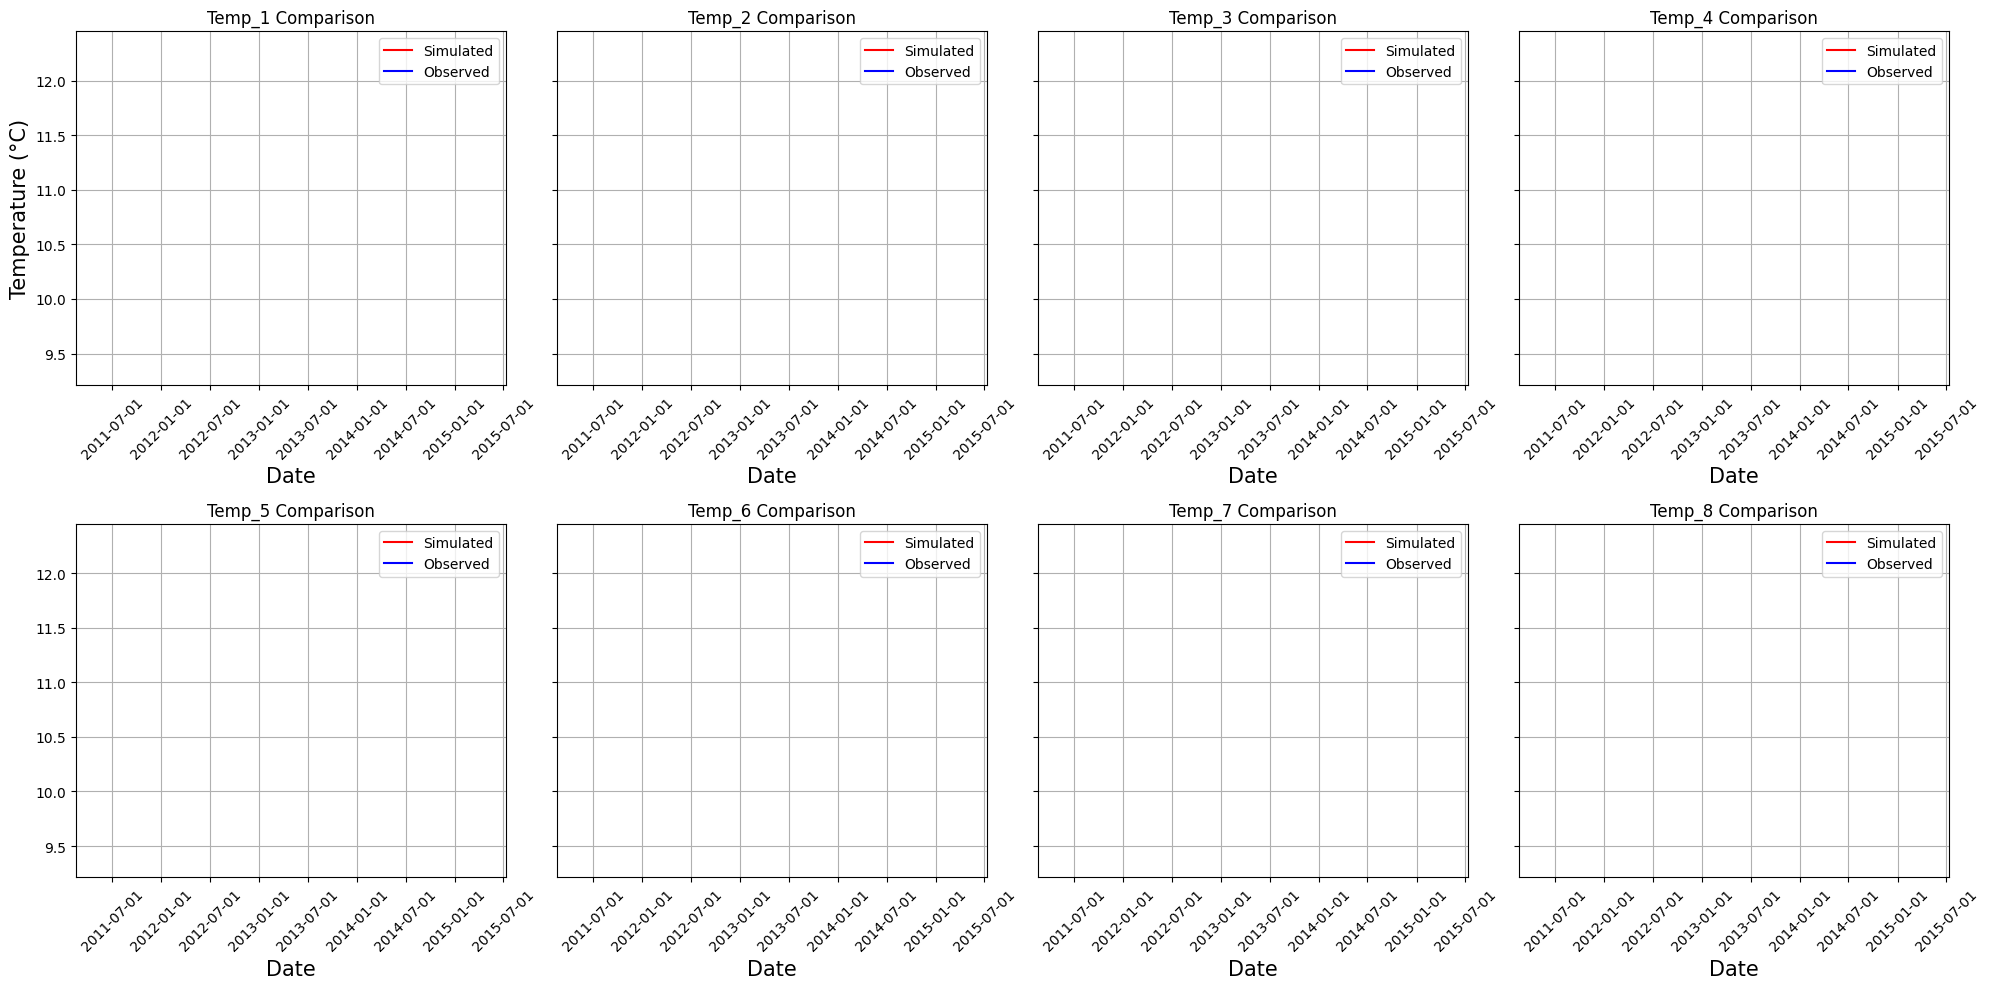

In [ ]:
from src.src_python.Plot import *
importlib.reload(Plot)
temp_columns=['Temp_1', 'Temp_2', 'Temp_3', 'Temp_4', 'Temp_5', 'Temp_6', 'Temp_7', 'Temp_8']
# plot the results
plot_compare_temperatures_obs_sim(
    sim_temp=sim_temp,
    obs_temp=obs_temp,
    temp_columns=temp_columns,
    fontsize=15)